<a href="https://colab.research.google.com/github/Ayesha-Imr/vision-mech-interp/blob/main/ayesha-imr__segment_2_activation_max.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segment 02: Activation Maximization

**Goal**: Understand what neurons in a neural network "see" by generating images that maximally activate them.

Normally we ask: *"Given this image, what does the network predict?"*

Activation maximization flips this: *"What image would make this specific neuron most excited?"*

We do this by:
1. Starting with random noise
2. Freezing the network weights
3. Using gradient descent to modify the **pixels** (not weights) to maximize a neuron's activation

The resulting image reveals what pattern that neuron has learned to detect.

## Setup

In [1]:
!pip install -q torch-lucent

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.8/253.8 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.3 MB/s eta 0:00:00


In [2]:
import torch
import matplotlib.pyplot as plt

from lucent.optvis import render, param, transform, objectives
from lucent.modelzoo import inceptionv1

# Load pretrained InceptionV1 (GoogLeNet)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = inceptionv1(pretrained=True).to(device).eval()

print(f"Using device: {device}")

Downloading: "https://github.com/ProGamerGov/pytorch-old-tensorflow-models/raw/master/inception5h.pth" to /root/.cache/torch/hub/checkpoints/inception5h.pth


100%|██████████| 27.0M/27.0M [00:00<00:00, 242MB/s]


Using device: cuda


## Part 1: Visualizing the First 10 Neurons of `mixed4a`

The `mixed4a` layer is a middle layer in InceptionV1. Neurons here typically respond to textures, patterns, and simple object parts, more complex than edges but simpler than whole objects.

Let's generate activation maximization images for channels 0-9.

In [3]:
# Generate visualizations for channels 0-9 of mixed4a
layer = "mixed4a"
num_channels = 10
image_size = 1024   # Higher resolution (default is 128) — more pixels = finer detail
num_steps = 1024    # More optimization steps — gives the optimizer longer to refine

visualizations = []
for ch in range(num_channels):
    print(f"Generating visualization for {layer}:{ch}")
    param_f = lambda: param.image(image_size, fft=True, decorrelate=True)
    imgs = render.render_vis(model, f"{layer}:{ch}", param_f, show_inline=False, thresholds=(num_steps,))
    visualizations.append(imgs[0][0])  # Get the final image

Generating visualization for mixed4a:0


100%|██████████| 1024/1024 [02:23<00:00,  7.15it/s]


Generating visualization for mixed4a:1


100%|██████████| 1024/1024 [02:23<00:00,  7.11it/s]


Generating visualization for mixed4a:2


100%|██████████| 1024/1024 [02:24<00:00,  7.06it/s]


Generating visualization for mixed4a:3


100%|██████████| 1024/1024 [02:24<00:00,  7.07it/s]


Generating visualization for mixed4a:4


100%|██████████| 1024/1024 [02:23<00:00,  7.12it/s]


Generating visualization for mixed4a:5


100%|██████████| 1024/1024 [02:23<00:00,  7.11it/s]


Generating visualization for mixed4a:6


100%|██████████| 1024/1024 [02:24<00:00,  7.09it/s]


Generating visualization for mixed4a:7


100%|██████████| 1024/1024 [02:24<00:00,  7.10it/s]


Generating visualization for mixed4a:8


100%|██████████| 1024/1024 [02:24<00:00,  7.10it/s]


Generating visualization for mixed4a:9


100%|██████████| 1024/1024 [02:24<00:00,  7.07it/s]


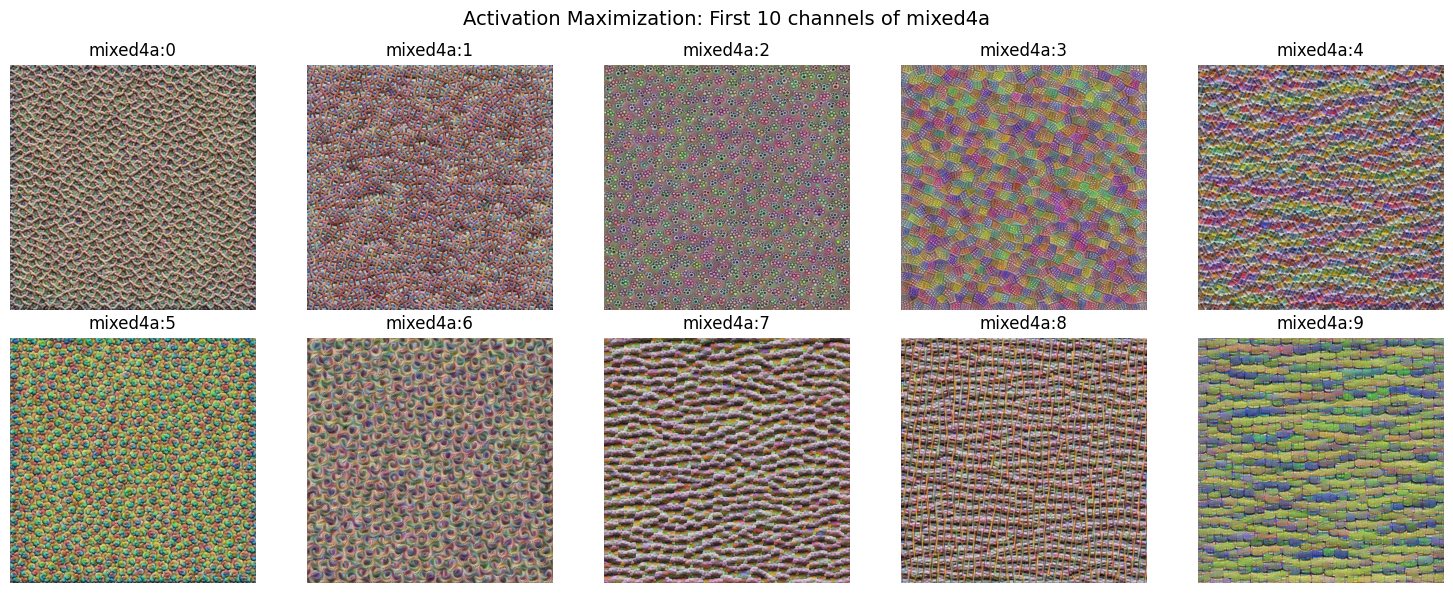

In [4]:
# Display all 10 visualizations in a grid
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, (ax, img) in enumerate(zip(axes, visualizations)):
    ax.imshow(img)
    ax.set_title(f"{layer}:{i}")
    ax.axis("off")

plt.suptitle(f"Activation Maximization: First 10 channels of {layer}", fontsize=14)
plt.tight_layout()
plt.show()

### Observations

Look at the generated images above. Each one shows what that particular neuron "wants to see":

- Some neurons might detect **textures** (fur, scales, patterns)
- Some might detect **colors** or color gradients
- Some might detect **shapes** or curves
- Some might be harder to interpret

## Part 2: The Effect of Parameterization

The "parameterization" is *how* we represent the image during optimization. This choice has a significant impact on interpretability.

Let's compare different parameterizations on a single neuron:

In [5]:
# Pick one channel to study in detail
test_channel = 5
obj = objectives.channel(layer, test_channel)

# Different parameterization settings
param_configs = [
    {"name": "Pixel (naive)", "fft": False, "decorrelate": False},
    {"name": "FFT only", "fft": True, "decorrelate": False},
    {"name": "Decorrelate only", "fft": False, "decorrelate": True},
    {"name": "FFT + Decorrelate (default)", "fft": True, "decorrelate": True},
]

param_results = []
for cfg in param_configs:
    print(f"Testing: {cfg['name']}")
    param_f = lambda fft=cfg["fft"], dec=cfg["decorrelate"]: param.image(128, fft=fft, decorrelate=dec)
    imgs = render.render_vis(model, obj, param_f, transforms=[], show_inline=False, thresholds=(1024,))
    param_results.append((cfg["name"], imgs[0][0]))

Testing: Pixel (naive)


100%|██████████| 1024/1024 [00:24<00:00, 42.09it/s]


Testing: FFT only


100%|██████████| 1024/1024 [00:24<00:00, 41.59it/s]


Testing: Decorrelate only


100%|██████████| 1024/1024 [00:26<00:00, 38.46it/s]


Testing: FFT + Decorrelate (default)


100%|██████████| 1024/1024 [00:27<00:00, 37.17it/s]


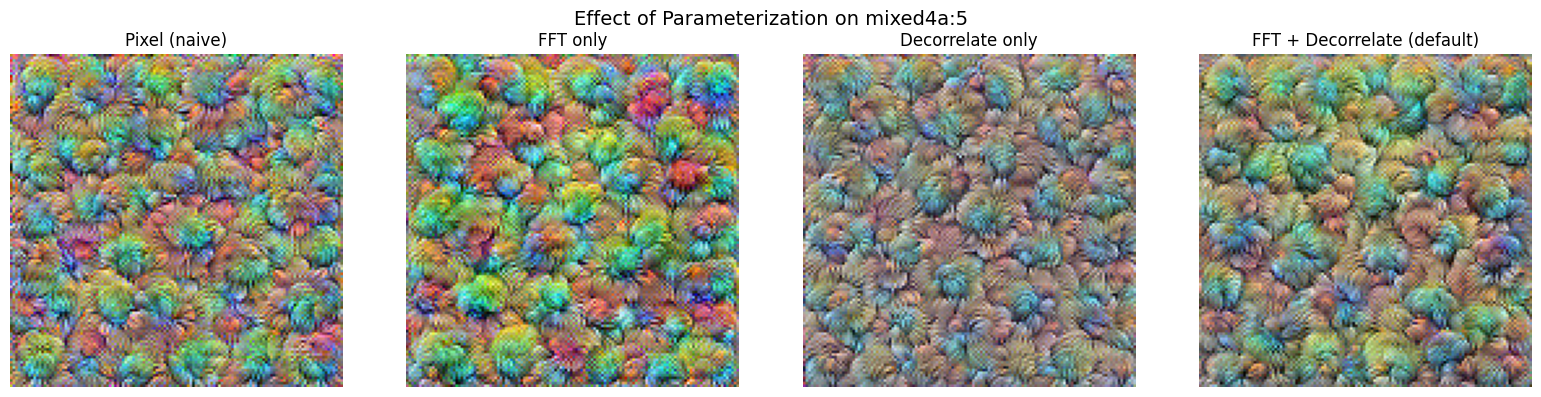

In [6]:
# Compare parameterizations
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for ax, (name, img) in zip(axes, param_results):
    ax.imshow(img)
    ax.set_title(name)
    ax.axis("off")

plt.suptitle(f"Effect of Parameterization on {layer}:{test_channel}", fontsize=14)
plt.tight_layout()
plt.show()

### What's happening here?

| Parameterization | What it does | Visual effect |
|-----------------|--------------|---------------|
| **Pixel (naive)** | Optimizes raw pixels directly | High-frequency noise (adversarial-like) |
| **FFT** | Optimizes in frequency domain with 1/f scaling | Smoother, prefers low frequencies |
| **Decorrelate** | Transforms to independent color space | More natural color combinations |
| **FFT + Decorrelate** | Both | Most interpretable results |

The FFT parameterization encodes a "prior" that natural images have mostly low frequencies. Without it, the optimizer finds high-frequency patterns that activate the neuron but look like noise to us.

## Part 3: The Effect of Transforms

Transforms are augmentations applied *during* optimization. They prevent the optimizer from finding position-specific tricks.

In [7]:
# Compare with and without transforms
transform_configs = [
    {"name": "No transforms", "transforms": []},
    {"name": "Jitter only", "transforms": [transform.jitter(8)]},
    {"name": "Standard transforms", "transforms": transform.standard_transforms},
]

transform_results = []
for cfg in transform_configs:
    print(f"Testing: {cfg['name']}")
    imgs = render.render_vis(model, obj, transforms=cfg["transforms"], show_inline=False, thresholds=(1024,))
    transform_results.append((cfg["name"], imgs[0][0]))

Testing: No transforms


100%|██████████| 1024/1024 [00:26<00:00, 38.31it/s]


Testing: Jitter only


100%|██████████| 1024/1024 [00:26<00:00, 38.63it/s]


Testing: Standard transforms


100%|██████████| 1024/1024 [00:30<00:00, 33.20it/s]


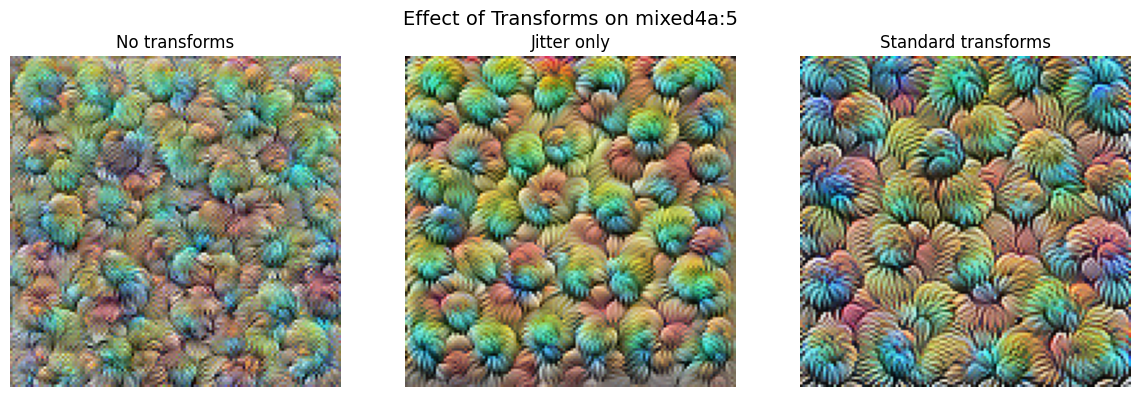

In [8]:
# Compare transforms
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, (name, img) in zip(axes, transform_results):
    ax.imshow(img)
    ax.set_title(name)
    ax.axis("off")

plt.suptitle(f"Effect of Transforms on {layer}:{test_channel}", fontsize=14)
plt.tight_layout()
plt.show()

### Why transforms matter

Without transforms, the optimizer might learn: *"put pattern X at exactly pixel (50, 50)"*.

With jitter/rotation/scale, it must find patterns that work at *any* position, revealing more generalizable features the neuron detects.

## Part 4: Comparing Layers

Let's see how features change across network depth. Earlier layers detect simpler patterns; later layers detect more complex, abstract concepts.

In [9]:
# Compare same channel index across different layers
layers_to_compare = ["conv2d2", "mixed3a", "mixed4a", "mixed5a"]
channel_idx = 3  # Arbitrary channel

layer_results = []
for lyr in layers_to_compare:
    print(f"Visualizing {lyr}:{channel_idx}")
    imgs = render.render_vis(model, f"{lyr}:{channel_idx}", show_inline=False, thresholds=(1024,))
    layer_results.append((lyr, imgs[0][0]))

Visualizing conv2d2:3


100%|██████████| 1024/1024 [00:21<00:00, 46.81it/s]


Visualizing mixed3a:3


100%|██████████| 1024/1024 [00:25<00:00, 40.58it/s]


Visualizing mixed4a:3


100%|██████████| 1024/1024 [00:30<00:00, 33.11it/s]


Visualizing mixed5a:3


100%|██████████| 1024/1024 [00:44<00:00, 23.01it/s]


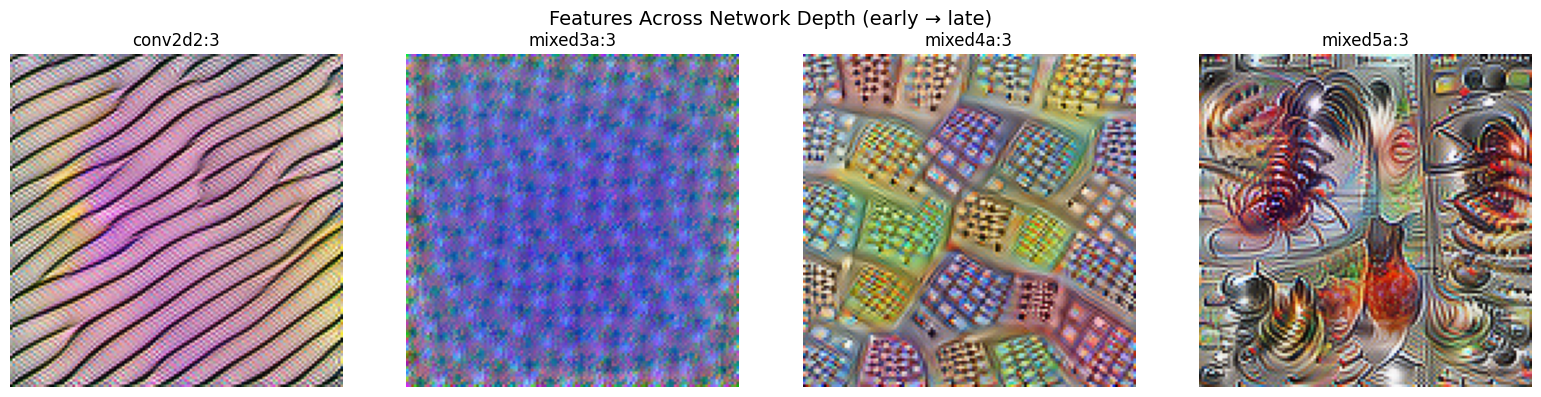

In [10]:
# Compare across layers
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for ax, (lyr, img) in zip(axes, layer_results):
    ax.imshow(img)
    ax.set_title(f"{lyr}:{channel_idx}")
    ax.axis("off")

plt.suptitle("Features Across Network Depth (early → late)", fontsize=14)
plt.tight_layout()
plt.show()

### Observation

- **Early layers** (conv2d2): Simple edges, colors, Gabor-like filters
- **Middle layers** (mixed3a, mixed4a): Textures, patterns, object parts
- **Late layers** (mixed5a): More complex, sometimes recognizable objects